# **Travie**

Travie is a friendly and smart travel assistant. It can:

🗺️ Provide information about travel destinations.

🧳 Plan a travel itinerary based on the number of days and the destination.

In [ ]:
#Install the required dependencies

!pip install -qU langchain langsmith groq langchain-groq wikipedia

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 1.9 MB/s eta 0:00:00


In [ ]:
import os
import json
from typing import Dict, List, Optional, Any, Type

In [ ]:
# LangChain imports
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.tools import BaseTool, tool
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage
from langchain.schema import AgentAction, AgentFinish
from langchain.callbacks.base import BaseCallbackHandler

In [ ]:
# LangSmith imports for tracking
from langsmith import Client
from langsmith.run_helpers import traceable

In [ ]:
# Update with your API URLs
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "lsv2"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
project_name = "Travie"  # Update with your project name
os.environ["LANGCHAIN_PROJECT"] = project_name  # Optional: "default" is used if not set
os.environ["GROQ_API_KEY"] = "gsk"

In [ ]:
#Building Custom Tools

from langchain.tools import tool
import wikipedia

@tool
def get_destination_info(destination: str) -> str:
    """Provides a summary about the destination using Wikipedia."""
    try:
        summary = wikipedia.summary(destination, sentences=3)
        return f"Here's what I found about {destination}: {summary}"
    except wikipedia.exceptions.DisambiguationError as e:
        return f"{destination} is ambiguous. Did you mean: {e.options[:3]}?"
    except wikipedia.exceptions.PageError:
        return f"Sorry, I couldn't find any information on {destination}."
    except Exception as e:
        return f"Something went wrong: {str(e)}"

@tool
def generate_itinerary(destination: str, days: int) -> str:
    """Generates a simple travel itinerary for the given destination and number of days."""
    itinerary = f"Here's a sample {days}-day itinerary for {destination}:\n\n"
    for day in range(1, days + 1):
        itinerary += f"Day {day}: Explore popular attractions, try local food, and enjoy the culture of {destination}.\n"
    itinerary += "\nYou can customize this based on your interests!"
    return itinerary

In [ ]:
#Choose the Groq LLM

llm= ChatGroq(model="llama3-8b-8192", temperature=0.2)

In [ ]:
# Create system prompt

system_prompt = """You are an expert travel planning assistant. Your job is to create comprehensive,
            personalized travel plans based on user requests.

            When planning a trip, you should:
            1. Get detailed destination information using get_destination_info
            2. Create a day-by-day itinerary with specific recommendations
            3. Provide practical travel tips and safety warnings

            Always use the available tools to get accurate information before creating your plan.
            Be thorough but concise, and always prioritize traveler safety and enjoyment.

            Tool usage examples:
            - get_destination_info: Use with just the destination name like "Tokyo"
            - generate_itinerary: Use with "destination,days" like "Tokyo,5"

            If you encounter limitations, provide helpful alternatives and suggestions.
            """

# Create prompt template

prompt = ChatPromptTemplate.from_messages([
                ("system", system_prompt),
                ("human", "{input}"),
                MessagesPlaceholder(variable_name="agent_scratchpad")
            ])

In [ ]:
# Create agent
agent = create_tool_calling_agent( llm=llm, tools= [get_destination_info,generate_itinerary], prompt=prompt)

In [ ]:
#LETS SEE HOW IT WORKSSS!!!!

agent_executor = AgentExecutor(agent=agent, tools=[get_destination_info,generate_itinerary], verbose=True)
raw_response= agent_executor.invoke({"input": "I want to go to UK"})



> Entering new AgentExecutor chain...

Invoking: `get_destination_info` with `{'destination': 'UK'}`




/usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


UK is ambiguous. Did you mean: ['Us (pronoun)', 'US', 'Us (Brother Ali album)']?
Invoking: `get_destination_info` with `{'destination': 'United Kingdom'}`
responded: I apologize for the ambiguity. It seems that the tool returned a list of possible destinations, but I'm assuming you meant the United Kingdom. Let me try again.



Here's what I found about United Kingdom: The United Kingdom of Great Britain and Northern Ireland, commonly known as the United Kingdom (UK) or Britain, is a country in Northwestern Europe, off the coast of the continental mainland. It comprises England, Scotland, Wales and Northern Ireland. The UK includes the island of Great Britain, the north-eastern part of the island of Ireland, and most of the smaller islands within the British Isles, covering 94,354 square miles (244,376 km2).Here's a personalized travel plan for you:

The United Kingdom is a country with a rich history, diverse culture, and breathtaking landscapes. With four distinct countries - England

In [ ]:
print(raw_response)

{'input': 'I want to go to Tokyo', 'output': 'Tokyo is a fascinating city with a rich history and culture. As the capital and most populous city in Japan, it offers a unique blend of traditional and modern attractions.\n\nFor a 5-day trip to Tokyo, I would recommend the following itinerary:\n\nDay 1: Arrival and Exploring Shinjuku\n- Arrive at Narita or Haneda airport and take a train or bus to your hotel\n- Visit the Tokyo Metropolitan Government Building for a free observation deck with great views of the city\n- Explore the Shinjuku Gyoen National Garden, a beautiful park with Japanese, French, and English landscaping\n- Enjoy dinner at a local restaurant, such as a sushi or ramen shop\n\nDay 2: Asakusa and Ueno\n- Visit Senso-ji Temple in Asakusa, one of the oldest and most famous temples in Japan\n- Explore the nearby Nakamise Shopping Street, a historic pedestrian street filled with traditional snacks and souvenirs\n- Visit the Ueno Park, a popular spot for cherry blossom viewing

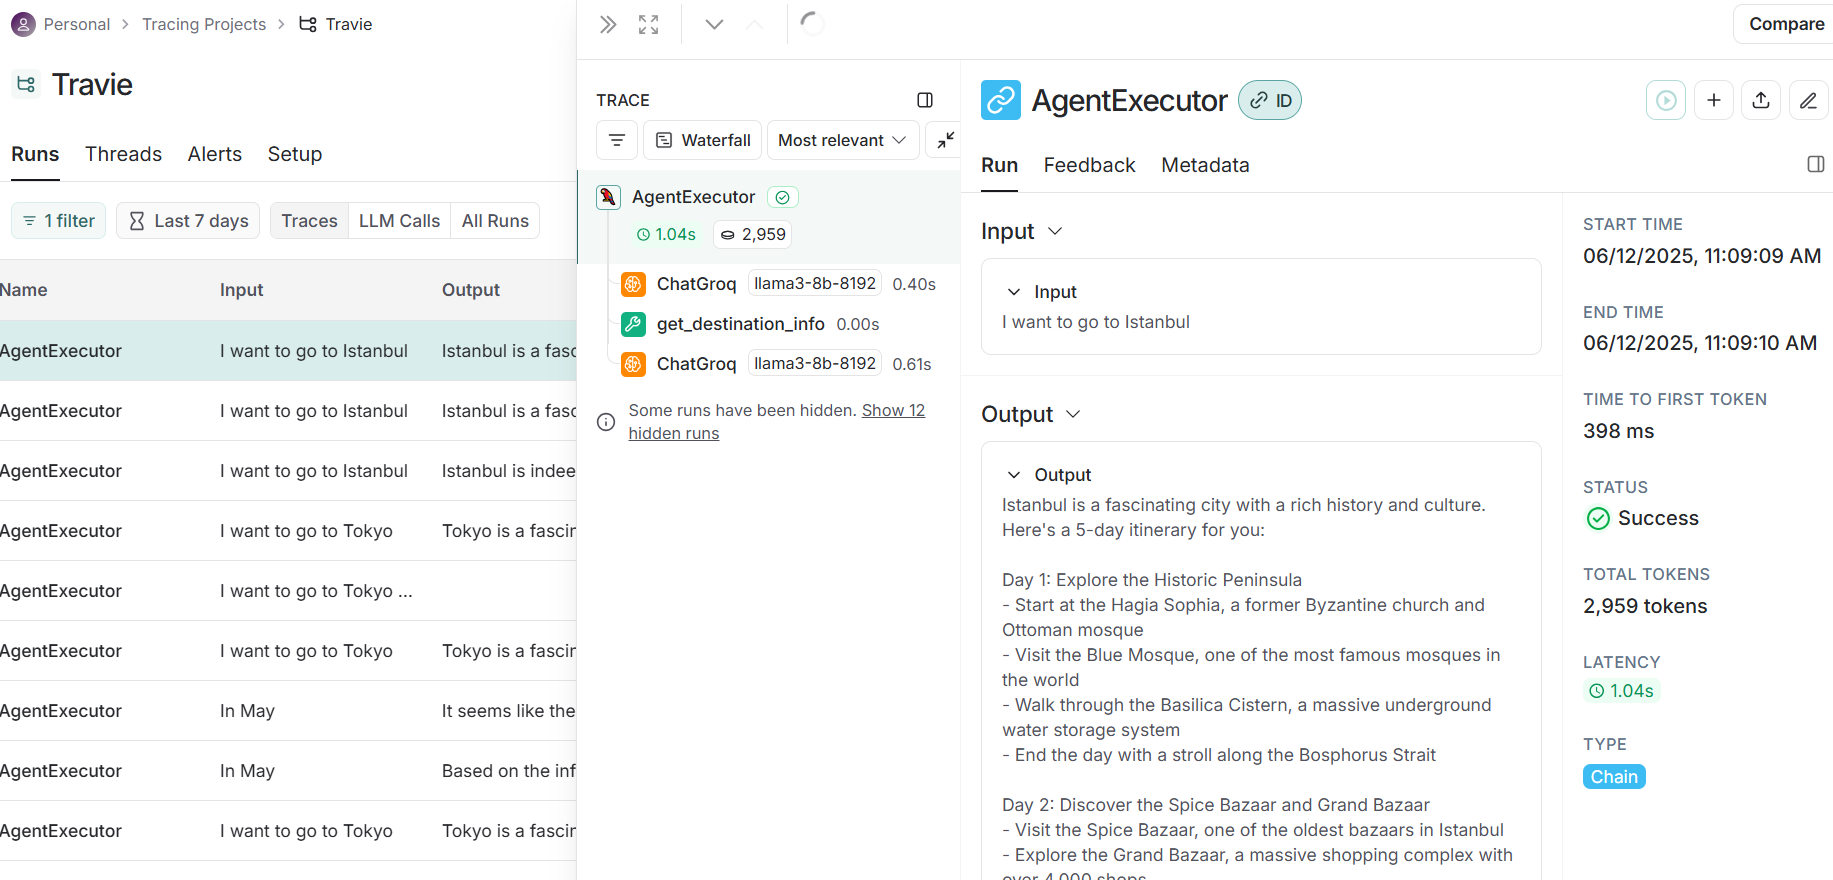